In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import EnvironmentNetwork
from src.runner import Runner
import random
import json
from sklearn import preprocessing

### Generate the baseline data

In [3]:
population = pd.read_csv('population.csv')

In [4]:
infection_states_base = []
for idx in range(90):
    infection_states_base.append(nx.read_graphml("measurement/baseline/network_time{}.graphml".format(idx), node_type=int))

In [5]:
susceptible_ot_base = []
infected_1_ot_base = []
infected_2_ot_base = []
critical_ot_base = []
dead_ot_base = []
recovered_ot_base = []

for t in range(90):
    network = infection_states_base[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot_base.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot_base.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot_base.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot_base.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot_base.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot_base.append((recovered / float(len(network)))  * population['Population'].sum())

# Experiments

There are three initial experiments which are compared to a baseline of no policy interventions. These three scenarios are:

1. A five week lock-down
2. A five week lock-down but without effect in the Townships
3. A lock down for vulnerable people

### Experiment 1: five week lockdown

In [6]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [7]:
parameters = {
    # general simulation parameters
    "time": 90,
    "number_of_agents": 500,
    "monte_carlo_runs": 1,
    "high_performance": False,
    # specific simulation parameters
    "share_inital_agents_infected": 0.01, # percentage of agents infected randomly at the start of the simulation
    "highest_density_neighbourhood": 0.4, # percentage of nodes the highest density neighbourhoods has compared to caveman graph
    "incubation_days": 5, # average number of days agents are infected but do not have symptoms SOURCE Zhang et al. 2020
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 8, # average number of days agents are in critical condition
    "health_system_capacity": 0.0021, # relative (in terms of population) capacity of the hospitals
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "travel_sample_size": 0.02, # amount of agents that an agent might choose to travel to
    # agent parameters
    "probability_transmission": 0.25, # should be estimated to replicate realistic R0 number.
    "probability_to_travel": 0.3, # should be estimated to replicate travel data 
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, # probability to die per age group in critical stage SOURCE: Verity et al.
    "probability_susceptible": 0.000, # probability that the agent will again be susceptible after having recovered
    # experiment parameter
    "lockdown_days" : [x for x in range(11, 57)], # 5 march was the first reported case, 27 (22 days later) march was the start of the lockdown 35 days
    "lockdown_travel_multiplier": 1.0 - ((0.85 + 0.62) / 2), # need estimate for this based on apple travel data reduction of 85% google work of -62% for Western Cape
    "lockdown_infection_multiplier": 0.27 # Jarvis et al. 2020
}

In [8]:
with open('parameters/lock_down/parameters.json', 'w') as outfile:
    json.dump(parameters, outfile)

In [9]:
smallest_size = population['Population'].sum() / parameters['number_of_agents']
neighbourhood_data = []
for i in range(len(population)):
    if population['Population'].iloc[i] > smallest_size:
        neighbourhood_data.append(
            [int(population['WardID'].iloc[i]), {'Population': population['Population'].iloc[i],
                                                 'Density': population['Density'].iloc[i],
                                                 'lon': population['lon'].iloc[i],
                                                 'lat': population['lat'].iloc[i]
                                                },
            ])
max_neighbourhoods = len(neighbourhood_data)

In [10]:
with open('parameters/lock_down/neighbourhood_data.json', 'w') as outfile:
    json.dump(neighbourhood_data[:max_neighbourhoods], outfile)

In [11]:
# load age data
age_distribution = pd.read_csv('age_dist.csv', sep=';', index_col=0)
age_distribution_per_ward = dict(age_distribution.transpose())

### Run lockdown experiment

In [12]:
environment = EnvironmentNetwork(0, parameters, neighbourhood_data, age_distribution_per_ward)
runner = Runner()
runner.lock_down(environment, 0)

Safe network

In [13]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml_lxml(network, "measurement/lockdown/network_time{}.graphml".format(idx))

In [14]:
infection_states = []
for idx in range(parameters["time"]):
    infection_states.append(nx.read_graphml("measurement/lockdown/network_time{}.graphml".format(idx), node_type=int))

In [15]:
susceptible_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(parameters['time']):
    network = infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot.append((recovered / float(len(network)))  * population['Population'].sum())

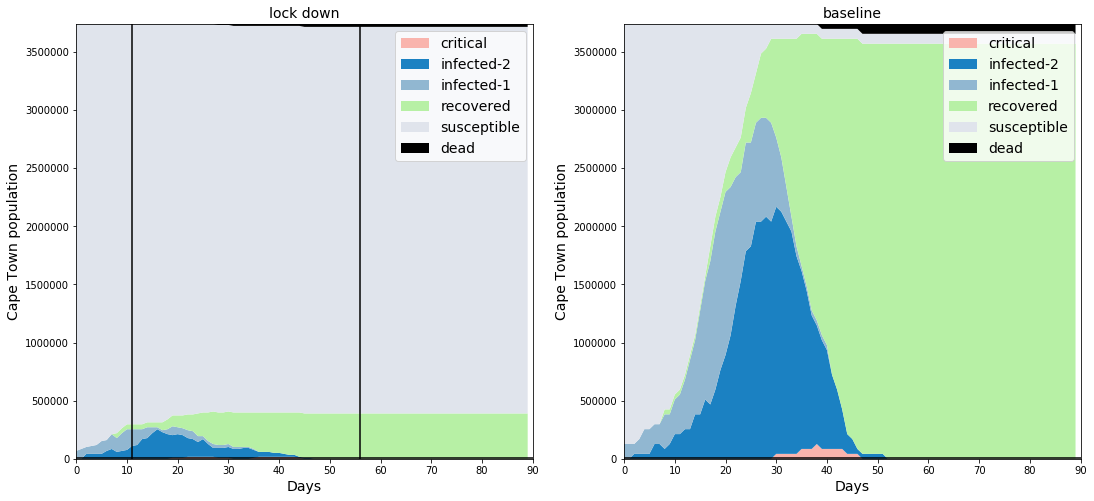

In [16]:
fig, (ax, ax_base) = plt.subplots(1, 2, figsize=(18,8))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax.axvline(parameters["lockdown_days"][0], color='black')
ax.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

ax.set_xlim([0,parameters['time']])
ax.set_ylim([0, population['Population'].sum()])
ax.set_title('lock down', fontsize='14')

# baseline
y_base = np.vstack([critical_ot_base, infected_2_ot_base, infected_1_ot_base, recovered_ot_base, susceptible_ot_base, dead_ot_base])

ax_base.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax_base.stackplot(x, y_base, colors= pal, labels=labels)
ax_base.legend(loc='best', fontsize='14', frameon=True)
ax_base.set_ylabel('Cape Town population', fontsize='14')
ax_base.set_xlabel('Days', fontsize='14')

ax_base.set_xlim([0,parameters['time']])
ax_base.set_ylim([0, population['Population'].sum()])

ax_base.set_title('baseline', fontsize='14')

fig.savefig('measurement/lock_down_v_no_lockdown.png')

### Experiment 2: five week lockdown but less effect in informal settlements. 

In [17]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [18]:
parameters = {
    # general simulation parameters
    "time": 90,
    "number_of_agents": 500,
    "monte_carlo_runs": 1,
    "high_performance": False,
    # specific simulation parameters
    "share_inital_agents_infected": 0.01, # percentage of agents infected randomly at the start of the simulation
    "highest_density_neighbourhood": 0.4, # percentage of nodes the highest density neighbourhoods has compared to caveman graph
    "incubation_days": 5, # average number of days agents are infected but do not have symptoms SOURCE Zhang et al. 2020
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 8, # average number of days agents are in critical condition
    "health_system_capacity": 0.0021, # relative (in terms of population) capacity of the hospitals
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "travel_sample_size": 0.02, # amount of agents that an agent might choose to travel to
    # agent parameters
    "probability_transmission": 0.25, # should be estimated to replicate realistic R0 number.
    "probability_to_travel": 0.3, # should be estimated to replicate travel data 
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, # probability to die per age group in critical stage SOURCE: Verity et al.
    "probability_susceptible": 0.000, # probability that the agent will again be susceptible after having recovered
    # experiment parameter
    "lockdown_days" : [x for x in range(11, 57)], # 5 march was the first reported case, 27 march was the start of the lockdown 35 days
    "lockdown_travel_multiplier": 1.0 - ((0.85 + 0.62) / 2), # need estimate for this based on apple travel data reduction of 85% google work of -62% for Western Cape
    "lockdown_infection_multiplier": 0.27 # Jarvis et al. 2020
}

In [19]:
with open('parameters/ineffective_lock_down/parameters.json', 'w') as outfile:
    json.dump(parameters, outfile)

Include in population file the informality of Wards and translate that to simulation data. 

In [20]:
informal_residential = pd.read_csv('Informal_Residential.csv').iloc[:-1]

In [21]:
# Create x, where x the 'scores' column's values as floats
x = informal_residential[['Informal_residential']].values.astype(float)

# # Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# # Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# # Run the normalizer on the dataframe
informal_residential['Informal_residential'] = pd.DataFrame(x_scaled)

In [22]:
population = pd.read_csv('population.csv')

In [23]:
population['Informal_residential'] = informal_residential['Informal_residential']

In [24]:
population.head(3)

,WardID,Population,Area,Density,lon,lat,Informal_residential
0,19100001,26434.07345,27213.359916,0.971364,18.612025,-33.857307,0.0
1,19100002,29914.18993,9222.458013,3.243624,18.422324,-34.069837,0.0
2,19100003,25735.62250,10891.277732,2.362957,18.476290,-34.048938,0.0


In [25]:
smallest_size = population['Population'].sum() / parameters['number_of_agents']
neighbourhood_data = []
for i in range(len(population)):
    if population['Population'].iloc[i] > smallest_size:
        neighbourhood_data.append(
            [int(population['WardID'].iloc[i]), {'Population': population['Population'].iloc[i],
                                                 'Density': population['Density'].iloc[i],
                                                 'lon': population['lon'].iloc[i],
                                                 'lat': population['lat'].iloc[i],
                                                 'Informal_residential': population['Informal_residential'].iloc[i]
                                                },
            ])
max_neighbourhoods = len(neighbourhood_data)

In [26]:
with open('parameters/ineffective_lock_down/neighbourhood_data.json', 'w') as outfile:
    json.dump(neighbourhood_data[:max_neighbourhoods], outfile)

In [27]:
# load age data
age_distribution = pd.read_csv('age_dist.csv', sep=';', index_col=0)
age_distribution_per_ward = dict(age_distribution.transpose())

### Run limited effectiveness lockdown scenario

In [28]:
environment = EnvironmentNetwork(0, parameters, neighbourhood_data, age_distribution_per_ward)
runner = Runner()
runner.ineffective_lock_down(environment, 0)

Safe network

In [29]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml_lxml(network, "measurement/inef_lockdown/network_time{}.graphml".format(idx))

In [30]:
infection_states = []
for idx in range(parameters["time"]):
    infection_states.append(nx.read_graphml("measurement/inef_lockdown/network_time{}.graphml".format(idx), node_type=int))

In [31]:
susceptible_ot_if = []
infected_1_ot_if = []
infected_2_ot_if = []
critical_ot_if = []
dead_ot_if = []
recovered_ot_if = []

for t in range(parameters['time']):
    network = infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot_if.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot_if.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot_if.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot_if.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot_if.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot_if.append((recovered / float(len(network)))  * population['Population'].sum())

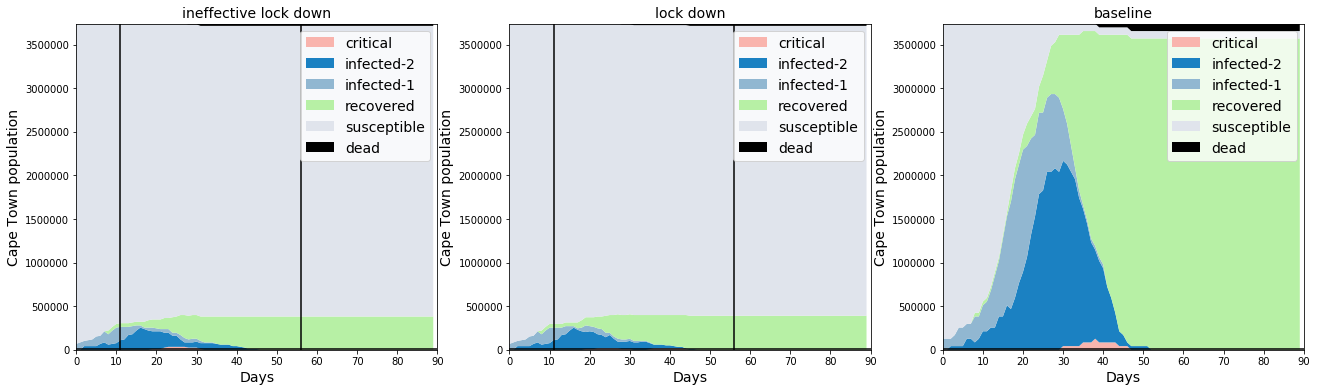

In [32]:
fig, (ax, ax3, ax_base) = plt.subplots(1, 3, figsize=(22,6))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot_if, infected_2_ot_if, infected_1_ot_if, recovered_ot_if, susceptible_ot_if, dead_ot_if])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax.axvline(parameters["lockdown_days"][0], color='black')
ax.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

ax.set_xlim([0,parameters['time']])
ax.set_ylim([0, population['Population'].sum()])
ax.set_title('ineffective lock down', fontsize='14')

# baseline
y_base = np.vstack([critical_ot_base, infected_2_ot_base, infected_1_ot_base, recovered_ot_base, susceptible_ot_base, dead_ot_base])

ax_base.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax_base.stackplot(x, y_base, colors= pal, labels=labels)
ax_base.legend(loc='best', fontsize='14', frameon=True)
ax_base.set_ylabel('Cape Town population', fontsize='14')
ax_base.set_xlabel('Days', fontsize='14')

ax_base.set_xlim([0,parameters['time']])
ax_base.set_ylim([0, population['Population'].sum()])

ax_base.set_title('baseline', fontsize='14')

# lockdown
y3 = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax3.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax3.axvline(parameters["lockdown_days"][0], color='black')
ax3.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax3.stackplot(x, y3, colors= pal, labels=labels)
ax3.legend(loc='best', fontsize='14', frameon=True)
ax3.set_ylabel('Cape Town population', fontsize='14')
ax3.set_xlabel('Days', fontsize='14')

ax3.set_xlim([0,parameters['time']])
ax3.set_ylim([0, population['Population'].sum()])
ax3.set_title('lock down', fontsize='14')

fig.savefig('measurement/lock_down_v_if_lockdown.png')

# Experiment 3 lockdown for at risk groups only 

In [84]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

In [86]:
parameters = {
    # general simulation parameters
    "time": 90,
    "number_of_agents": 10000,
    "monte_carlo_runs": 1,
    "high_performance": False,
    # specific simulation parameters
    "share_inital_agents_infected": 0.01, # percentage of agents infected randomly at the start of the simulation
    "highest_density_neighbourhood": 0.4, # percentage of nodes the highest density neighbourhoods has compared to caveman graph
    "incubation_days": 5, # average number of days agents are infected but do not have symptoms SOURCE Zhang et al. 2020
    "symptom_days": 10,# average number of days agents have mild symptoms
    "critical_days": 8, # average number of days agents are in critical condition
    "health_system_capacity": 0.0021, # relative (in terms of population) capacity of the hospitals
    "no_hospital_multiplier": 1.79, # the increase in probability if a critical agent cannot go to the hospital SOURCE: Zhou et al. 2020
    "travel_sample_size": 0.02, # amount of agents that an agent might choose to travel to
    # agent parameters
    "probability_transmission": 0.1, # should be estimated to replicate realistic R0 number.
    "probability_to_travel": 0.3, # should be estimated to replicate travel data 
    "probability_critical": {key:value for key, value in zip(age_groups, [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])}, # probability that an agent enters a critical stage of the disease SOURCE: Verity et al.
    "probability_to_die": {key:value for key, value in zip(age_groups, [0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])}, # probability to die per age group in critical stage SOURCE: Verity et al.
    "probability_susceptible": 0.000, # probability that the agent will again be susceptible after having recovered
    # experiment parameter
    "lockdown_days" : [x for x in range(11, 46)], # 5 march was the first reported case, 27 march was the start of the lockdown 35 days
    "lockdown_travel_multiplier": 1.0 - ((0.85 + 0.62) / 2), # need estimate for this based on apple travel data reduction of 85% google work of -62% for Western Cape
    "lockdown_infection_multiplier": 0.27, # Jarvis et al. 2020
    "high_risk_groups": age_groups[-4:]
}

In [ ]:
with open('parameters/clustercomputer/parameters.json', 'w') as outfile:
    json.dump(parameters, outfile)

In [35]:
with open('parameters/lock_down_elderly/parameters.json', 'w') as outfile:
    json.dump(parameters, outfile)

Include in population file the informality of Wards and translate that to simulation data. 

In [36]:
informal_residential = pd.read_csv('Informal_Residential.csv').iloc[:-1]

In [37]:
# Create x, where x the 'scores' column's values as floats
x = informal_residential[['Informal_residential']].values.astype(float)

# # Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# # Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# # Run the normalizer on the dataframe
informal_residential['Informal_residential'] = pd.DataFrame(x_scaled)

In [38]:
population = pd.read_csv('population.csv')

In [39]:
population['Informal_residential'] = informal_residential['Informal_residential']

In [40]:
population.head(3)

,WardID,Population,Area,Density,lon,lat,Informal_residential
0,19100001,26434.07345,27213.359916,0.971364,18.612025,-33.857307,0.0
1,19100002,29914.18993,9222.458013,3.243624,18.422324,-34.069837,0.0
2,19100003,25735.62250,10891.277732,2.362957,18.476290,-34.048938,0.0


In [41]:
smallest_size = population['Population'].sum() / parameters['number_of_agents']
neighbourhood_data = []
for i in range(len(population)):
    if population['Population'].iloc[i] > smallest_size:
        neighbourhood_data.append(
            [int(population['WardID'].iloc[i]), {'Population': population['Population'].iloc[i],
                                                 'Density': population['Density'].iloc[i],
                                                 'lon': population['lon'].iloc[i],
                                                 'lat': population['lat'].iloc[i],
                                                 'Informal_residential': population['Informal_residential'].iloc[i]
                                                },
            ])
max_neighbourhoods = len(neighbourhood_data)

In [42]:
with open('parameters/lock_down_elderly/neighbourhood_data.json', 'w') as outfile:
    json.dump(neighbourhood_data[:max_neighbourhoods], outfile)

In [43]:
# load age data
age_distribution = pd.read_csv('age_dist.csv', sep=';', index_col=0)
age_distribution_per_ward = dict(age_distribution.transpose())

### Run limited effectiveness lockdown scenario

In [44]:
environment = EnvironmentNetwork(0, parameters, neighbourhood_data, age_distribution_per_ward)
runner = Runner()
runner.elderly_inef_lock_down(environment, 0)

Safe network

In [45]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml_lxml(network, "measurement/lock_down_elderly/network_time{}.graphml".format(idx))

In [46]:
infection_states = []
for idx in range(parameters["time"]):
    infection_states.append(nx.read_graphml("measurement/lock_down_elderly/network_time{}.graphml".format(idx), node_type=int))

In [47]:
susceptible_ot_if_e = []
infected_1_ot_if_e = []
infected_2_ot_if_e = []
critical_ot_if_e = []
dead_ot_if_e = []
recovered_ot_if_e = []

for t in range(parameters['time']):
    network = infection_states[t]
    susceptible = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot_if_e.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot_if_e.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot_if_e.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot_if_e.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot_if_e.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot_if_e.append((recovered / float(len(network)))  * population['Population'].sum())

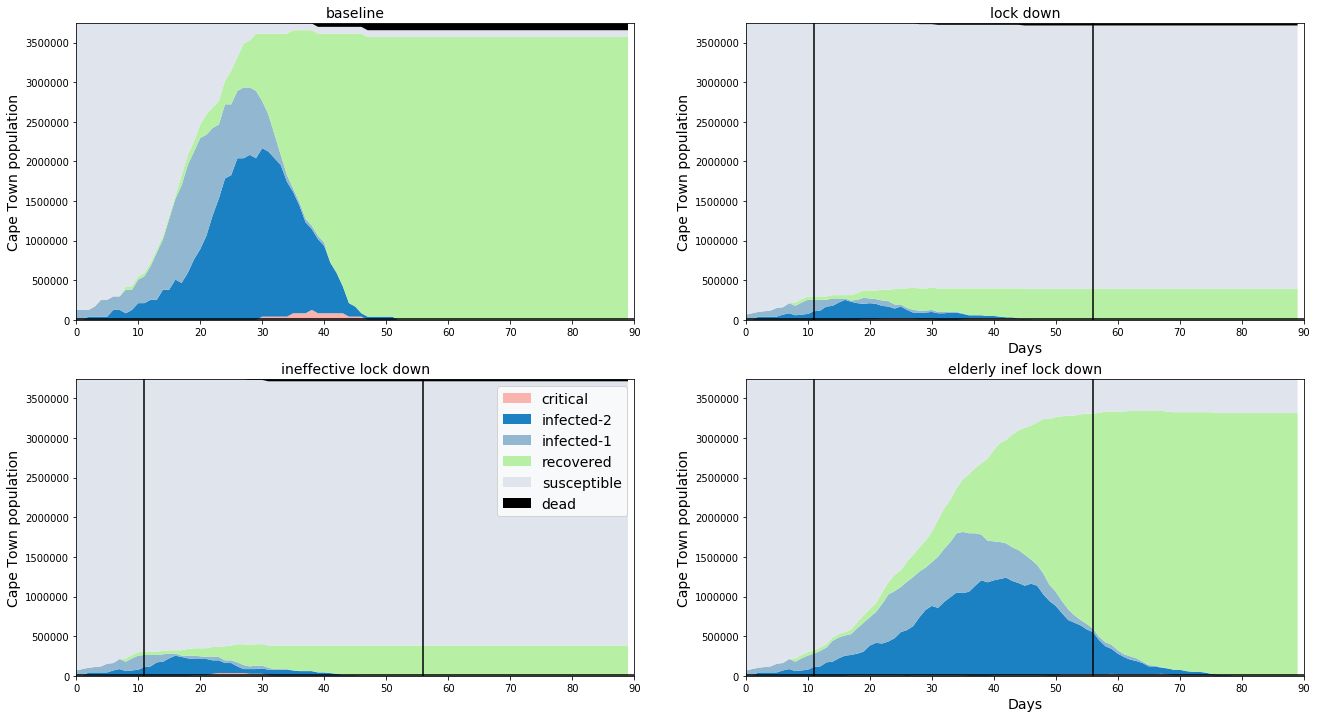

In [65]:
fig, ((ax_base, ax3), (ax, ax4)) = plt.subplots(2, 2, figsize=(22,12))

x = [x for x in range(parameters['time'])]

labels = ['critical', 'infected-2', 'infected-1', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot_if, infected_2_ot_if, infected_1_ot_if, recovered_ot_if, susceptible_ot_if, dead_ot_if])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax.axvline(parameters["lockdown_days"][0], color='black')
ax.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
#ax.set_xlabel('Days', fontsize='14')

ax.set_xlim([0,parameters['time']])
ax.set_ylim([0, population['Population'].sum()])
ax.set_title('ineffective lock down', fontsize='14')

# baseline
y_base = np.vstack([critical_ot_base, infected_2_ot_base, infected_1_ot_base, recovered_ot_base, susceptible_ot_base, dead_ot_base])

ax_base.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax_base.stackplot(x, y_base, colors= pal, labels=labels)
#ax_base.legend(loc='best', fontsize='14', frameon=True)
ax_base.set_ylabel('Cape Town population', fontsize='14')
#ax_base.set_xlabel('Days', fontsize='14')

ax_base.set_xlim([0,parameters['time']])
ax_base.set_ylim([0, population['Population'].sum()])

ax_base.set_title('baseline', fontsize='14')

# ineffective lockdown
y3 = np.vstack([critical_ot, infected_2_ot, infected_1_ot, recovered_ot, susceptible_ot, dead_ot])

ax3.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax3.axvline(parameters["lockdown_days"][0], color='black')
ax3.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax3.stackplot(x, y3, colors= pal, labels=labels)
#ax3.legend(loc='best', fontsize='14', frameon=True)
ax3.set_ylabel('Cape Town population', fontsize='14')
ax3.set_xlabel('Days', fontsize='14')

ax3.set_xlim([0,parameters['time']])
ax3.set_ylim([0, population['Population'].sum()])
ax3.set_title('lock down', fontsize='14')

# ineffective elderly lockdown
y4 = np.vstack([critical_ot_if_e, infected_2_ot_if_e, infected_1_ot_if_e, recovered_ot_if_e, susceptible_ot, dead_ot_if_e])

ax4.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')
ax4.axvline(parameters["lockdown_days"][0], color='black')
ax4.axvline(parameters["lockdown_days"][-1], color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b7f0a5", "#e0e4ec","#000000"]

ax4.stackplot(x, y4, colors= pal, labels=labels)
#ax4.legend(loc='best', fontsize='14', frameon=True)
ax4.set_ylabel('Cape Town population', fontsize='14')
ax4.set_xlabel('Days', fontsize='14')

ax4.set_xlim([0,parameters['time']])
ax4.set_ylim([0, population['Population'].sum()])
ax4.set_title('elderly inef lock down', fontsize='14')

fig.savefig('measurement/3experiments.png')

In [80]:
# total dead
columns = ['total dead', 'peak_critical', 'total_recovered']
experiment_summary = {'baseline': [int(dead_ot_base[-1]), int(max(critical_ot_base)), int(recovered_ot_base[-1])],
                      'lockdown': [int(dead_ot[-1]), int(max(critical_ot)), int(recovered_ot[-1])],
                      'inefficient lockdown': [int(dead_ot_if[-1]), int(max(critical_ot_if)), int(recovered_ot_if[-1])],
                      'inefficient elderly lockdown':[int(dead_ot_if_e[-1]), int(max(critical_ot_if_e)), int(recovered_ot_if_e[-1])] 
                     }

In [81]:
experiment_summary = pd.DataFrame(experiment_summary).transpose()

In [82]:
experiment_summary.columns = columns

In [83]:
experiment_summary

,total dead,peak_critical,total_recovered
baseline,85000,127501,3570029
lockdown,25442,16961,390116
inefficient lockdown,25442,33923,381635
inefficient elderly lockdown,59365,25442,3315990
